## Scaling for containers and algorithms

We've seen that NumPy arrays are really useful. Why wouldn't we always want to use them for data which is all the same type?

In [75]:
import numpy as np
from timeit import repeat
from matplotlib import pyplot as plt
%matplotlib inline

In [76]:
def time_append_to_ndarray(count):
    return repeat('np.append(before,[0])',
                  'import numpy as np; before=np.ndarray('+str(count)+')',
                  number=10000)

In [77]:
def time_append_to_list(count):
    return repeat('before.append(0)',
                  'before=[0]*'+str(count),
                  number=10000)

In [78]:
counts=np.arange(1,100000,10000)

(0, 0.0018000000000000002)

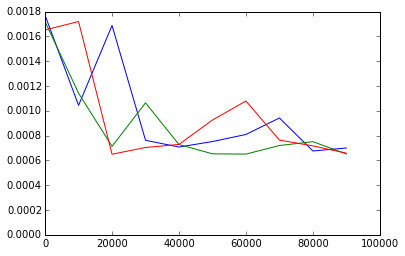

In [79]:
plt.plot(counts,map(time_append_to_list,counts))
plt.ylim(ymin=0)

(0, 0.5)

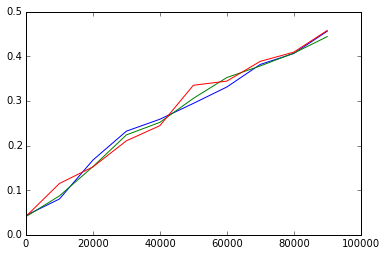

In [80]:
plt.plot(counts,map(time_append_to_ndarray,counts))
plt.ylim(ymin=0)

Both scale well for accessing the middle element:

In [81]:
def time_lookup_middle_element_in_list(count):
    before=[0]*count
    def totime():
        x=before[count/2]
    return repeat(totime,number=10000)

In [82]:
def time_lookup_middle_element_in_ndarray(count):
    before=np.ndarray(count)
    def totime():
        x=before[count/2]
    return repeat(totime,number=10000)


(0, 0.0060000000000000001)

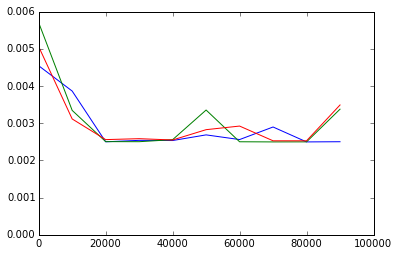

In [83]:
plt.plot(counts,map(time_lookup_middle_element_in_list,counts))
plt.ylim(ymin=0)


(0, 0.0065000000000000006)

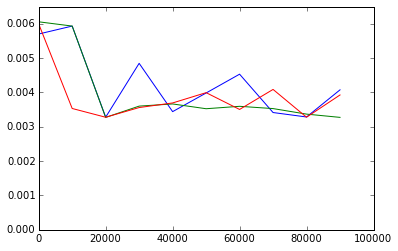

In [84]:
plt.plot(counts,map(time_lookup_middle_element_in_ndarray,counts))
plt.ylim(ymin=0)

But a list performs badly for insertions at the beginning:

In [85]:
x=range(5)

In [86]:
x

[0, 1, 2, 3, 4]

In [87]:
x[0:0]=[-1]

In [88]:
x

[-1, 0, 1, 2, 3, 4]

In [89]:
def time_insert_to_list(count):
    return repeat('before[0:0]=[0]','before=[0]*'+str(count),number=10000)

(0, 0.40000000000000002)

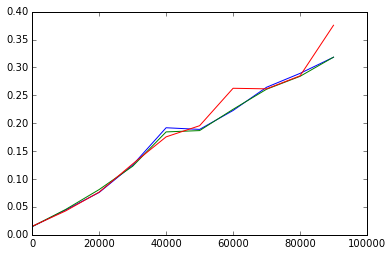

In [90]:
plt.plot(counts,map(time_insert_to_list,counts))
plt.ylim(ymin=0)

There are containers in Python that work well for insertion at the start:

In [91]:
from collections import deque

In [92]:
def time_insert_to_deque(count):
    return repeat('before.appendleft(0)','from collections import deque; before=deque([0]*'+str(count)+')',number=10000)

(0, 0.0012999999999999999)

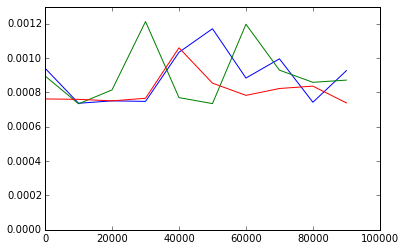

In [93]:
plt.plot(counts,map(time_insert_to_deque,counts))
plt.ylim(ymin=0)

But looking up in the middle scales badly:

In [94]:
def time_lookup_middle_element_in_deque(count):
    before=deque([0]*count)
    def totime():
        x=before[count/2]
    return repeat(totime,number=10000)

(0, 0.080000000000000002)

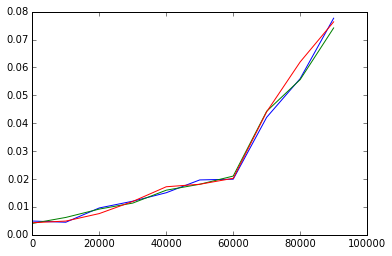

In [95]:
plt.plot(counts,map(time_lookup_middle_element_in_deque,counts))
plt.ylim(ymin=0)

What is going on here?

Arrays are stored as contiguous memory. Anything which changes the length of the array requires the whole array to be copied elsewhere in memory.

This copy takes time proportional to the array size.

The Python `list` type is **also** an array, but it is allocated with **extra memory**. Only when that memory is exhausted is a copy needed.

If the extra memory is typically the size of the current array, a copy is needed every 1/N appends, and costs N to make, so **on average** copies are cheap. We call this **amortized constant time**. 

The deque type works differently: each element contains a pointer to the next. Inserting elements is therefore very cheap, but looking up the Nth element requires traversing N such pointers.

### Dictionary performance

For another example, let's consider the performance of a dictionary versus a couple of other ways in which we could implement an associative array.

In [96]:
class evildict(object):
    def __init__(self,data):
        self.data=data
        
    def __getitem__(self,akey):
        for key,value in self.data:
            if key==akey:
                return value
        raise KeyError()

In [97]:
me=[["Name","James"],["Job","Programmer"],["Home","London"]]

In [98]:
me_evil=evildict(me)

In [99]:
me_evil["Job"]

'Programmer'

In [100]:
me_dict=dict(me)

In [101]:
me_evil["Job"]

'Programmer'

In [102]:
x=["Hello", "Goodbye", "whatever", "something", "this", "apple"]

In [103]:
sorted(x, key=lambda el: el.lower())

['apple', 'Goodbye', 'Hello', 'something', 'this', 'whatever']

In [104]:
class sorteddict(object):
    def __init__(self, data):
        self.data=sorted(data, key = lambda x:x[0])
        self.keys=map(lambda x:x[0],self.data)
        
    def __getitem__(self,akey):
        from bisect import bisect_left
        loc=bisect_left(self.keys, akey)
        
        if loc!=len(self.data):
            return self.data[loc][1]
        
        raise KeyError()

In [105]:
me_sorted=sorteddict(me)

In [106]:
me_sorted["Job"]

'Programmer'

In [107]:
def time_dict_generic(ttype,count,number=10000):
    from random import randrange
    keys=range(count)
    values=[0]*count
    data=ttype(zip(keys,values))
    def totime():
        x=data[keys[count/2]]
    return repeat(totime,number=10000)

In [108]:
time_dict=lambda count: time_dict_generic(dict, count)
time_sorted=lambda count: time_dict_generic(sorteddict, count)
time_evil=lambda count: time_dict_generic(evildict, count)

(0, 0.034000000000000002)

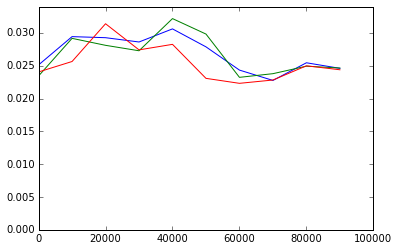

In [109]:
plt.plot(counts,map(time_sorted,counts))
plt.ylim(ymin=0)

We can't really see what's going on here for the sorted example as there's too much noise, but theoretically we should get **logarithmic** asymptotic performance. We write this down as $O(\ln N)$. This doesn't mean there isn't also a constant term, or a term proportional to something that grows slower (such as $\ln(\ln N)$): we always write down just the term that is dominant for large $N$. We saw before that `list` is $O(1)$ for appends, $O(N)$ for inserts. Numpy's `array` is $O(N)$ for appends.

(0, 0.17999999999999999)

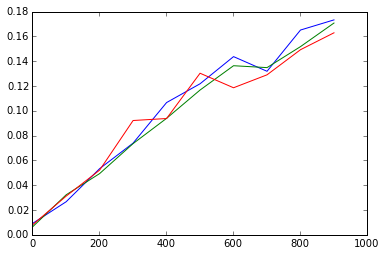

In [110]:
counts=np.arange(1,1000,100)
plt.plot(counts,map(time_evil,counts))
plt.ylim(ymin=0)

The simple check-each-in-turn solution is $O(N)$ - linear time.

(0, 0.007000000000000001)

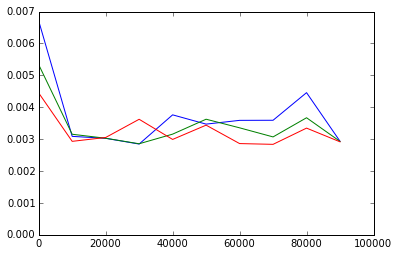

In [113]:
counts=np.arange(1,100000,10000)
plt.plot(counts,map(time_dict,counts))
plt.ylim(ymin=0)

Python's built-in dictionary is, amazingly, O(1): the time is **independent** of the size of the dictionary.

This uses a miracle of programming called the Hash Table:
you can learn more about these issues [here](https://www.youtube.com/watch?v=h2d9b_nEzoA) This material is pretty advanced, but, I think, really interesting!

Optional exercise: determine what the asymptotic peformance for the Boids model in terms of the number of Boids. Make graphs to support this. Bonus: how would the performance scale with the number of dimensions?